In [54]:
import pandas as pd
import numpy as np
import sympy as sp
import sympy
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('path/to/ShotReceData.csv')
# 通过条件筛选出符合要求的行
df_50010001_1001 = df[(df['ShotNum'] == 50010001) & (df['ReceNum'].between(10010001, 10010100))]
df_50010001_1002 = df[(df['ShotNum'] == 50010001) & (df['ReceNum'].between(10020001, 10020100))]

#定义参数
#定义sigma
sigma = 2
#定义h
h = 40
#定义size
size = 100
#定义右端f_k
f = sp.Matrix(df_50010001_1001['First Time'].to_numpy())

#创建等号左端三对角
def create_tridiagonal_matrix1(size):
    matrix = sp.zeros(size, size)

    for i in range(size):
        if i == 0:
            matrix[i, i] = 1
        elif i == size - 1:
            matrix[i, i] = 1
        else:
            matrix[i, i] = 2
            matrix[i, i-1] = 0.5
            matrix[i, i+1] = 0.5

    return matrix

tri_mat1 = create_tridiagonal_matrix1(size)

#创建等号右端三对角
def create_tridiagonal_matrix2(size):
    matrix = sp.zeros(size, size)

    for i in range(size):
        if i in range(1 ,size-1 ):
            matrix[i, i] = -2
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1

    return matrix

tri_mat2 = create_tridiagonal_matrix2(size)

#定义等号右端五对角
def create_fivediagonal_matrix(size):
    matrix = sympy.zeros(size, size)

    for i in range(size):
        if i == 1:
            matrix[i, i-1] = 3
            matrix[i, i] = -6
            matrix[i, i+1] = 4
            matrix[i, i+2] = -1
        elif i == size-2:
            matrix[i, i-2] = -1
            matrix[i, i-1] = 4
            matrix[i, i] = -6
            matrix[i, i+1] = 3
        elif i in range(2 ,size-2 ) :
            matrix[i, i-2] = -1
            matrix[i, i-1] = 4
            matrix[i, i] = -6
            matrix[i, i+1] = 4
            matrix[i, i+2] = -1

    return matrix

#分段样条函数
def S_k(x, k):
    return ( M[k-1]*(h*k - x)**3 ) / (6*h) +  ( M[k]*(x - h*(k-1))**3 ) / (6*h) + (Y[k-1] -  M[k-1]*h**2 / 6) * ((h*k - x) / h) + (Y[k] -  M[k]*h**2 / 6) * ((x-h*(k-1)) / h)

In [67]:
a_values = 10**np.linspace(-7, -6, 100)
s_values = []
n = size-1 # n=99
b = (3 / h ** 2) * tri_mat2 * f
five_mat = create_fivediagonal_matrix(size)

for a in a_values:
    A = tri_mat1 - (3 * sigma ** 2)/(a * h ** 3) * five_mat
    M = A.solve(b)
    Y = sympy.zeros(size, 1)
    Y[0] = (sigma**2 / (a*h)) * (M[0] - M[1]) + f[0]
    Y[n] = (sigma**2 / (a*h)) * (M[n] - M[n-1]) + f[n]
    for k in range(1, n):
        Y[k] = (sigma**2 / (a * h)) * (-M[k-1] + 2*M[k] - M[k+1]) + f[k]
    
    e = Y - f
    s = (e.T * e)[0]/ sigma**2
    s_values.append(s)

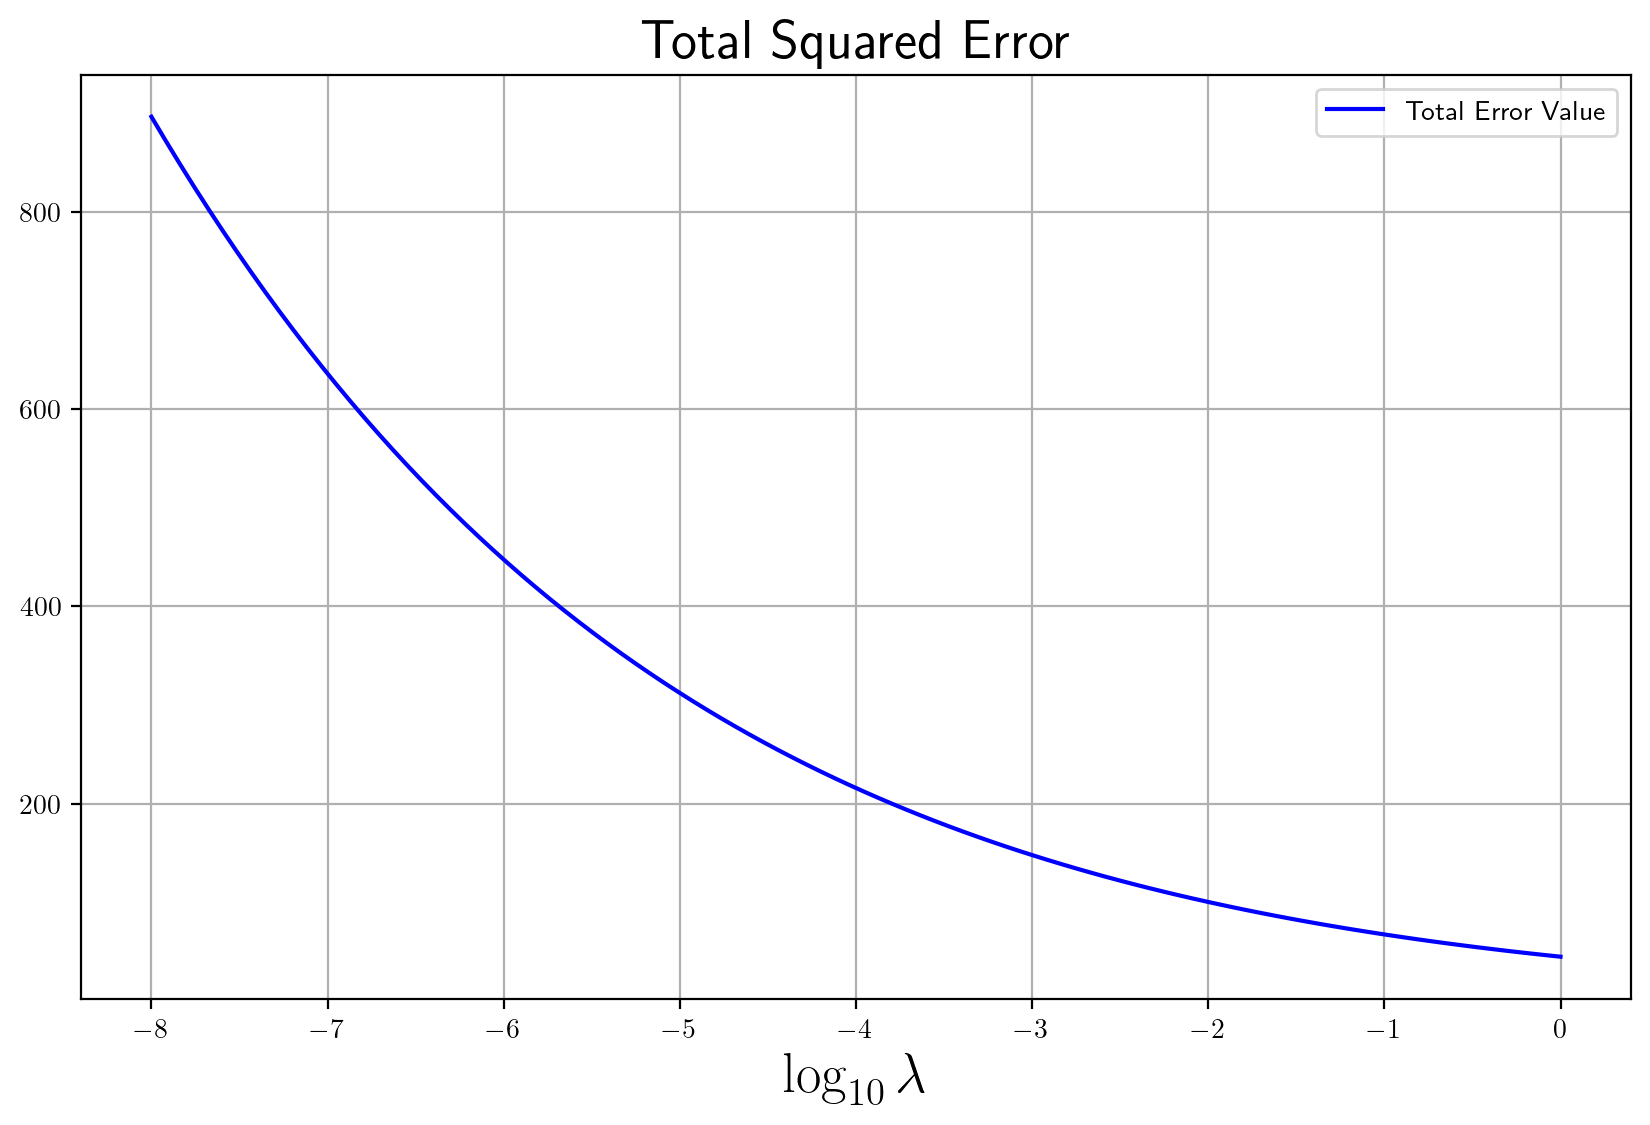

In [70]:
plt.rcParams.update({'text.usetex': True})
plt.figure(figsize=(10, 6))
plt.plot(np.log10(a_values), s_values, label='Total Error Value', color='b')
plt.xlabel('$\log_{10}\lambda$',fontsize=20)
plt.title('Total Squared Error',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [73]:
a_values = 10**np.linspace(-8, 0, 100)
integral_values = []
n = size-1 # n=99
x = sp.symbols('x')

for a in a_values:
    five_mat = create_fivediagonal_matrix(size)
    A = tri_mat1 - (3 * sigma ** 2)/(a * h ** 3) * five_mat
    M = A.solve(b)
    Y = sympy.zeros(size, 1)
    Y[0] = (sigma**2 / a*h) * (M[0] - M[1]) + f[0]
    Y[n] = (sigma**2 / a*h) * (M[n] - M[n-1]) + f[n]
    for k in range(1, n):
        Y[k] = sigma**2 / (a * h) * (-M[k-1] + 2*M[k] - M[k+1]) + f[k]

    total_integral_value = 0
    for k in range(1, size):
        S_k_double_prime = sp.diff(S_k(x, k), x, 2)
        integral_value = sp.integrate(S_k_double_prime ** 2, (x, h*(k-1), h*k))
        total_integral_value += integral_value

    integral_values.append(total_integral_value)

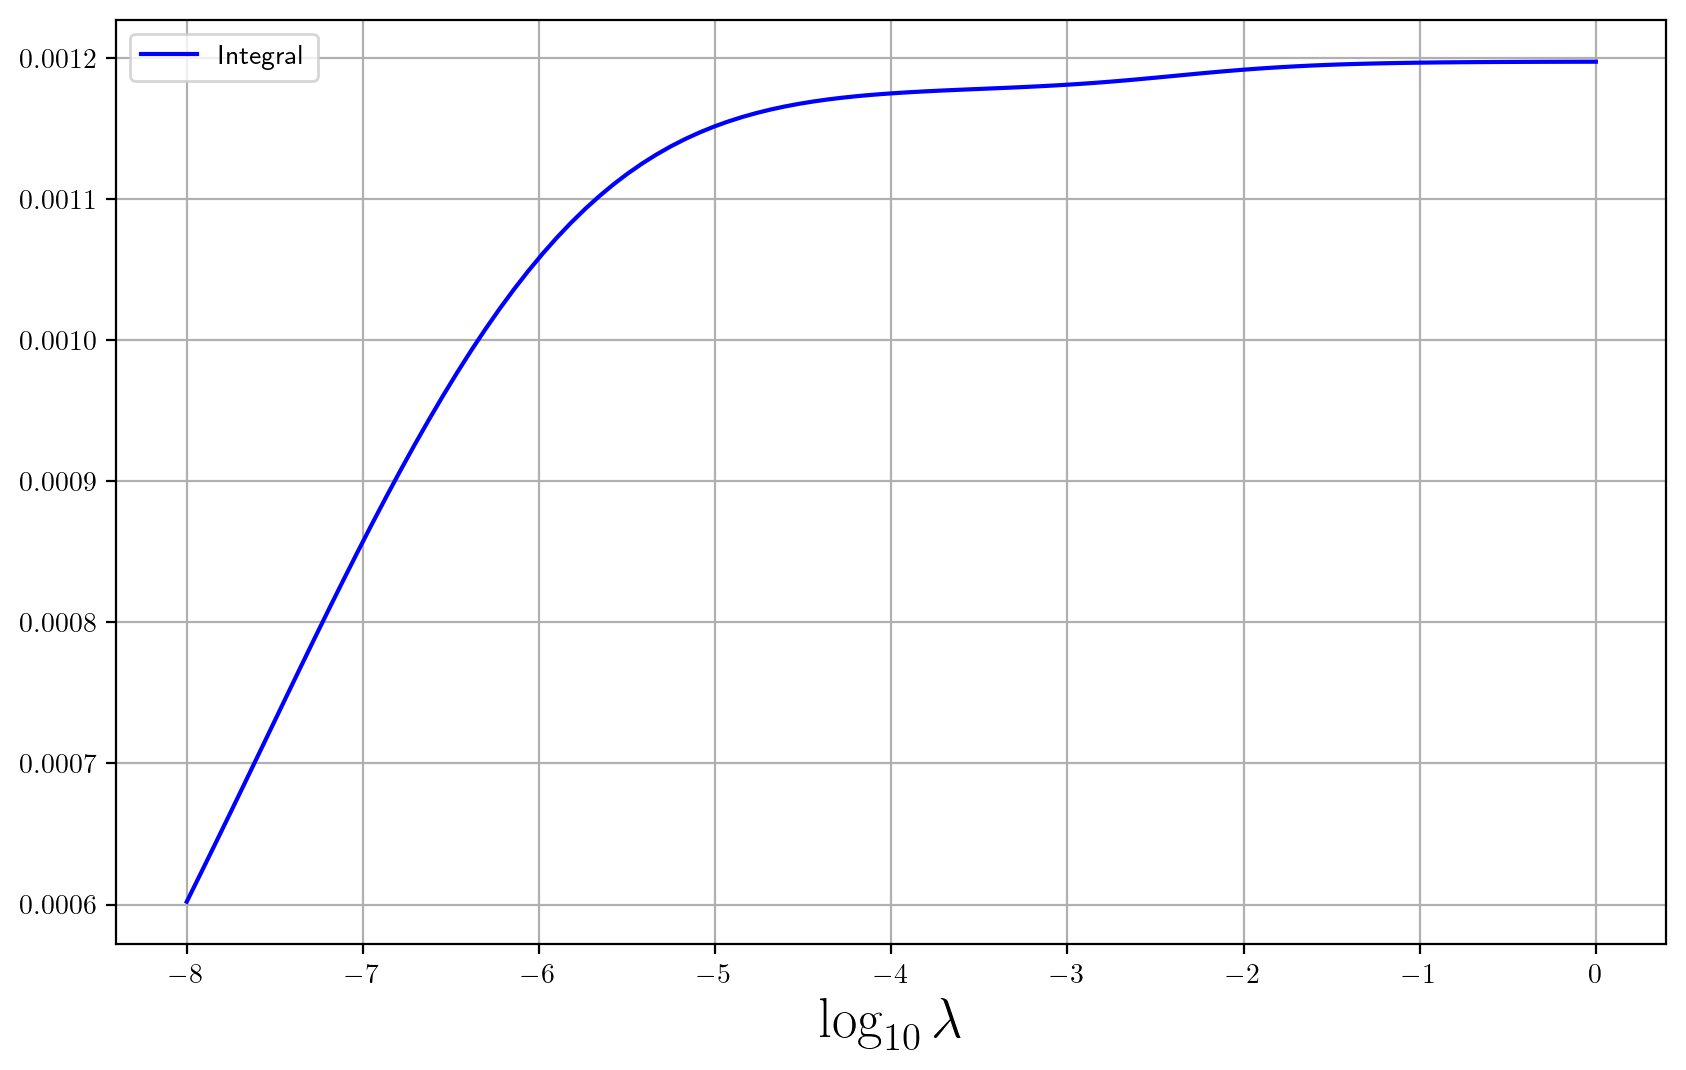

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(np.log10(a_values), integral_values, label='Integral', color='b')
plt.xlabel('$\log_{10}\lambda$',fontsize=20)
# plt.title('$$\int_{x_0}^{x_n}[FT''_{ij}(x)]^2 \mathrm{d}x$$',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()